In [1]:
from testproblems import generate_random_prob, random_problem_with_artifacts

In [2]:
from datastructures.operators import eqv_to_edges_tree, reformulate, invert_edges
from datastructures.graphutils import (default_tree, flat_graph_formulation, Node, COMP, VAR, sources, 
                                       draw_graph_graphical_props)
from datastructures.rendering import render_incidence
import networkx as nx
from datastructures.tearing import min_max_scc2, min_arc_set_assign, min_arc_set

In [3]:
from ipywidgets import interact, interactive, fixed, interact_manual

# Exploration

In [4]:
m = 10
n = 13
#seed 229 does not behave correctly
def func1(seed=229):
    sparsity = 1.
    kwargs = random_problem_with_artifacts(m,n,seed,sparsity)
    eq_incidence,outset,eqnidxs,edges_varonleft,varidxs = map(kwargs.get, ["eq_incidence","outset","eqnidxs","edges_varonleft","varidxs"])
    edges_dir,tree_dir,outset_adj = eqv_to_edges_tree(eq_incidence, outset, n_eqs=m)
    edges_undir,tree_undir,_ = eqv_to_edges_tree(eq_incidence, n_eqs=m)
    formulation_scc = reformulate(edges_dir, tree_dir, root_solver_name=1)
    render_incidence(*formulation_scc, figsize=((4,4)), patchwidth=3);
    xsol, model = min_arc_set_assign(edges_varonleft, varidxs, eqnidxs)
    outset_minassign = dict((right, left-m) for left, right in edges_varonleft if xsol[left, right] > 0.5)
    edges_minassign=invert_edges(edges_undir[0], edges_undir[1], outset_minassign) 
    formulation_minassign = reformulate(edges_undir, tree_dir, outset_adj, outset_minassign, root_solver_name=1)
    render_incidence(*formulation_minassign, figsize=((4,4)));
    xsol, model = min_max_scc2(edges_varonleft, varidxs, eqnidxs)
    outset_minscc = dict((right, left-m) for left, right in edges_varonleft if xsol[left, right] > 0.5)
    formulation_minscc = reformulate(edges_dir, tree_dir, outset_adj, outset_minscc, root_solver_name=1)
    render_incidence(*formulation_minscc, figsize=((4,4)));
interact(func1, seed=(200,300)); # 20 looks good

interactive(children=(IntSlider(value=229, description='seed', max=300, min=200), Output()), _dom_classes=('wi…

In [5]:
seed = 257#23
runs = (
    (0.5, 'sparsity_half.png'),
    (1., 'sparsity_one.png'),
    (1.5, 'sparsity_one_and_half.png')
)
sparsity, figname = 1., ''

In [6]:
kwargs = random_problem_with_artifacts(m,n,seed,sparsity)

In [7]:
eq_incidence,outset,eqnidxs,edges_varonleft,varidxs = map(kwargs.get, ["eq_incidence","outset","eqnidxs","edges_varonleft","varidxs"])

## Undirected formulation

In [8]:
edges_undir,tree_undir,_ = eqv_to_edges_tree(eq_incidence, n_eqs=m)
edges_dir,tree_dir,outset_adj = eqv_to_edges_tree(eq_incidence, outset, n_eqs=m)
tree_undir[2].update({val:1 for val in outset_adj.values()})

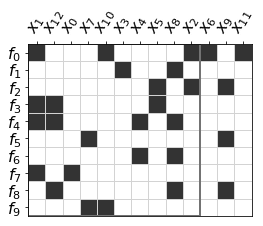

In [9]:
render_incidence(edges_undir, tree_undir, figsize=((4,4)));

In [36]:
A = generate_incidence_matrix(edges_dir[0], edges_dir[1], list(eqnidxs), [elt-m for elt in varidxs], diagonalgray=False)

In [55]:
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import splu
from datastructures.rendering import generate_incidence_matrix, plot_incidence_matrix
from scipy.sparse.csgraph import reverse_cuthill_mckee

In [48]:
Asq = csc_matrix(A[:,list(outset_adj.values())], dtype=float)
p = reverse_cuthill_mckee(Asq)

In [63]:
A

array([[0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.]])

In [57]:
Acm = (Asq.toarray()[p,:])[:,p]

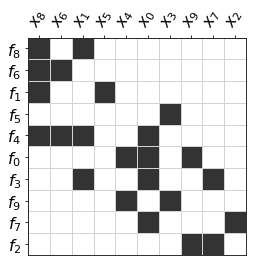

In [60]:
column_labels = ['$x_{}$'.format(var) for var in p]
row_labels = ['$f_{}$'.format(fx) for fx in p]
plot_incidence_matrix(Acm, column_labels, row_labels, **kwargs);

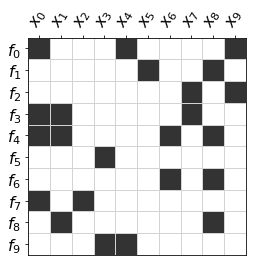

In [62]:
column_labels = ['$x_{}$'.format(var) for var in range(10)]
row_labels = ['$f_{}$'.format(fx) for fx in range(10)]
plot_incidence_matrix(Asq.toarray(), column_labels, row_labels, **kwargs);

## Directed formulation
Based on initial formulation

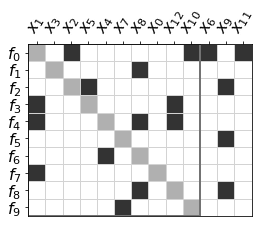

In [10]:
render_incidence(edges_dir, tree_dir, figsize=((4,4)));

## Condensation

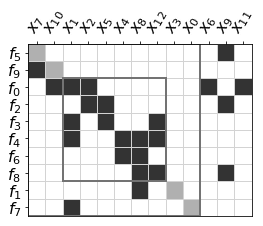

In [11]:
formulation_scc = reformulate(edges_dir, tree_dir, root_solver_name=1)
render_incidence(*formulation_scc, figsize=((4,4)));

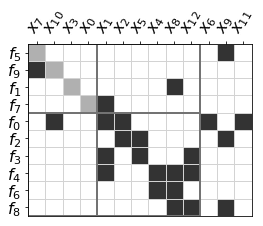

In [12]:
formulation_scc = reformulate(edges_dir, tree_dir, root_solver_name=1, mdf=False)
render_incidence(*formulation_scc, figsize=((4,4)));

## DM fine

In [13]:
#draw_graph_graphical_props(G, prog='neato', figsize=(11,4))

In [14]:
Ein_no_source = {comp:tuple(var for var in allvars if var in outset.values()) for comp,allvars in eq_incidence.items()}
G = flat_graph_formulation(Ein_no_source,{},{},{VAR: 'x_{{{}}}', COMP: 'f_{{{}}}'})
matching = nx.bipartite.maximum_matching(G)
m_out = {key: matching[Node(key, COMP)].name for key in eqnidxs}
edges_dir_m,tree_dir_m,_ = eqv_to_edges_tree(eq_incidence, m_out, n_eqs=m)

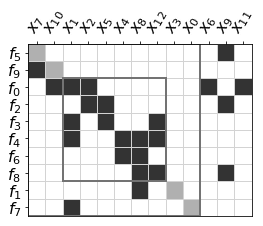

In [15]:
formulation_scc_m = reformulate(edges_dir_m, tree_dir_m, root_solver_name=1)
render_incidence(*formulation_scc_m, figsize=((4,4)));

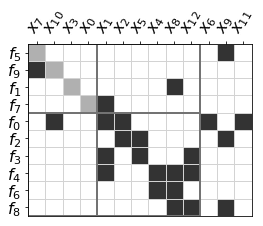

In [16]:
formulation_scc_m = reformulate(edges_dir_m, tree_dir_m, root_solver_name=1, mdf=False)
render_incidence(*formulation_scc_m, figsize=((4,4)));

## MFA

In [17]:
cycles, elimset, model = min_arc_set(edges_varonleft, outset, varidxs, eqnidxs)

In [18]:
elimset, {outset_adj[elt] for elt in elimset}

({0, 4}, {1, 4})

In [19]:
outset_mfa = {key:val for key,val in outset_adj.items() if key not in elimset}

### There is no IDF/MDF

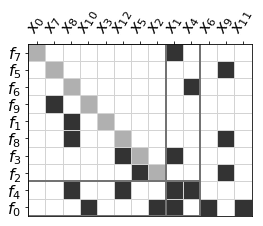

In [20]:
formulation_mfa = reformulate(edges_dir, tree_dir, outset_adj, outset_mfa, root_solver_name=1)
render_incidence(*formulation_mfa, figsize=((4,4)));

## Tearing

In [21]:
fixed_inputs = set(varidxs)-set(outset.values())

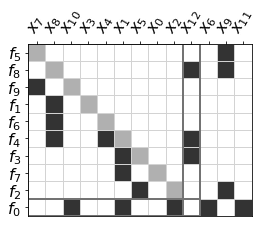

In [25]:
xsol, model = min_arc_set_assign(edges_varonleft, varidxs, eqnidxs, not_output=fixed_inputs)
outset_tear = dict((right, left-m) for left, right in edges_varonleft if xsol[left, right] > 0.5)
formulation_tear = reformulate(edges_dir, tree_dir, outset_adj, outset_tear, 
                               not_outputs={elt-m for elt in fixed_inputs},
                               root_solver_name=1)
render_incidence(*formulation_tear, figsize=((4,4)));

## Tearing with input

In [25]:
xsol, model = min_arc_set_assign(edges_varonleft, varidxs, eqnidxs)
outset_minassign = dict((right, left-m) for left, right in edges_varonleft if xsol[left, right] > 0.5)

In [26]:
edges_minassign=invert_edges(edges_undir[0], edges_undir[1], outset_minassign) 

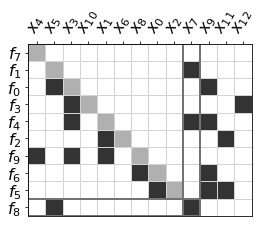

In [27]:
formulation_minassign = reformulate(edges_undir, tree_dir, outset_adj, outset_minassign, root_solver_name=1)
render_incidence(*formulation_minassign, figsize=((4,4)));

## Min scc

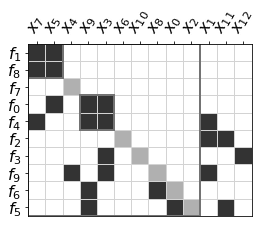

In [30]:
xsol, model = min_max_scc2(edges_varonleft, varidxs, eqnidxs)
outset_minscc = dict((right, left-m) for left, right in edges_varonleft if xsol[left, right] > 0.5)
formulation_minscc = reformulate(edges_dir, tree_dir, outset_adj, outset_minscc, root_solver_name=1)
render_incidence(*formulation_minscc, figsize=((4,4)));